# Character Classification
This notebook contains all steps of OCR

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Import Widgets
from ipywidgets import Button, Text, HBox, VBox
from IPython.display import display, clear_output

# Import costume functions, corresponding to notebooks
#from ocr import page, words, charSeg
from ocr.normalization import imageNorm, letterNorm
from ocr import page, words, charSeg
# Helpers
from ocr.helpers import implt, resize
from ocr.tfhelpers import Graph

Loading Segmantation model:
INFO:tensorflow:Restoring parameters from models/gap-clas/CNN-CG


### Global Variables

In [2]:
IMG = 'chars'
LANG = 'en'
LOC = 'models/char-clas/' + LANG + '/CharClassifier'
CLAS = 53

## Load Trained Model

In [3]:
charClass = Graph(LOC)

INFO:tensorflow:Restoring parameters from models/char-clas/en/CharClassifier


## Load image

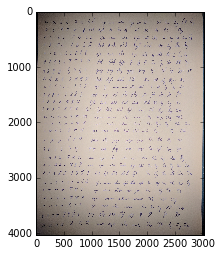

In [4]:
image = cv2.cvtColor(cv2.imread("data/pagedet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

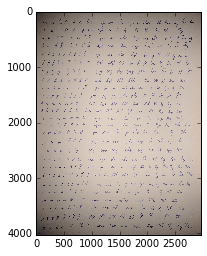

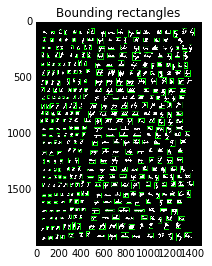

In [5]:
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

# Simple UI using widgets

In [6]:
class Cycler:
    """ Cycle through the chars, save data """
    height = 60
    
    def __init__(self, image, boxes, idx):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx         # Index of current bounding box
        self.charIdx = 0         # Position po slider
        self.actual = image      # Current image of word
        self.char = None         # Actual char image
        self.nextImg()
        
    def nextChar(self, b=None):
        """ Ploting next char from the word """        
        # Clearing jupyter output for new image
        clear_output()
        idx = self.charIdx
        gaps = self.gaps
        
        if idx < len(gaps) - 1:
            # Cutting char image - for save function
            self.char = self.actual[0:self.height, gaps[idx]:gaps[idx+1]]
            implt(self.char, 'gray')
            
            data = np.multiply(np.reshape(letterNorm(self.char), (1, 4096)).astype(np.float32),
                               1.0 / 255.0)

            print(charClass.run(data))
            
            self.charIdx += 1
        else:
            if self.nextImg() == -1:
                print("END")

    def nextImg(self, b=None):
        """ Getting next image from the array """
        clear_output()
        self.char = None
        self.charIdx = 0
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = self.image[y1:y2, x1:x2]
            img = resize(img, self.height, True)
            
            implt(img, t='Index: ' + str(self.index))            
            self.actual = imageNorm(img, self.height)
            
            self.gaps = charSeg.segmentation(self.actual, debug=True)
            
            self.index += 1
            return 0
        else:
            print("END")
            return -1

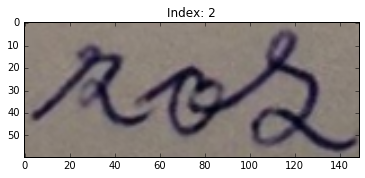

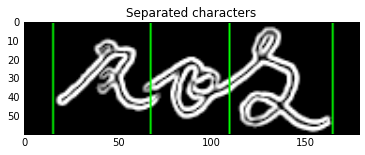

In [7]:
#  Last index
LAST_INDEX = 0
# Class cycling through text positions
cycler = Cycler(crop, bBoxes, LAST_INDEX)

bNex = Button(description="Next Char")
bNexi = Button(description="Next Image")

bNex.on_click(cycler.nextChar)
bNexi.on_click(cycler.nextImg)

VBox([HBox([bNexi, bNex])])